---
title: "[gene expression] 2. 유방암 아종 분류를 위한 미세조정" 
author: "agsu" 
date: "11/16/2023" 
format: html: 
code-fold: false 
jupyter: python3 
categories: [project, gene expression] 
image: ../image/gene2.png
---

# **2. 유방암 아종 분류를 위한 미세조정**

In [ ]:
import os
from tqdm import tqdm 

import numpy as np


import pandas as pd 


from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, train_test_split 
    
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.init as init


import matplotlib.pyplot as plt
# plt.style.use("seaborn-whitegrid")

import matplotlib.pyplot as plt               
plt.rc("font", family="NanumGothic", size=13) 

import warnings
warnings.filterwarnings('ignore')

<br> 

## **2.1 분류 데이터(유방암 아종 데이터) 전처리** 

In [5]:
data = pd.read_csv(f"data/BRCA.txt", delimiter="\t", skiprows=lambda x: x==1)
data = data.set_index("Hybridization REF")
data = data.drop(columns=data.select_dtypes(include="object").columns) # 데이터가 float 형이 아닌 columns 제거 
data = data.T
data.index = data.index.str[:15]
data

Hybridization REF,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932
TCGA-3C-AAAU-01,0.0000,16.3644,12.9316,52.1503,408.0760,0.0,1187.0050,0.0000,0.0000,0.0,...,129.5917,1007.7824,1658.4983,258.4941,1208.3738,3507.2482,1894.9342,1180.4565,1.7233,0.0000
TCGA-3C-AALI-01,0.0000,9.2659,17.3790,69.7553,563.8934,0.0,516.0413,1.0875,0.5438,0.0,...,59.8151,448.6134,1343.1213,198.4774,603.5889,5504.6221,1318.6514,406.7428,926.5905,0.0000
TCGA-3C-AALJ-01,0.9066,11.6228,9.2294,154.2974,1360.8341,0.0,592.0218,0.0000,0.0000,0.0,...,35.3581,533.9982,768.8123,331.8223,532.1850,5458.7489,942.8830,509.5195,35.3581,0.0000
TCGA-3C-AALK-01,0.0000,12.0894,11.0799,143.8643,865.5358,0.0,552.7513,0.4137,0.0000,0.0,...,55.0269,437.7327,863.8808,175.4241,607.3645,5691.3529,781.1336,700.8688,66.6115,0.0000
TCGA-4H-AAAK-01,0.0000,6.8468,14.4298,84.2128,766.3830,0.0,260.8511,0.4255,0.0000,0.0,...,48.9362,424.2553,1049.7872,14.0426,775.7447,4041.7021,831.9149,881.7021,187.2340,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-WT-AB44-01,0.0000,0.0000,3.2580,42.2643,1877.4180,0.0,704.5408,4.0725,0.0000,0.0,...,24.4349,243.5349,772.9587,98.5543,315.2108,10937.0800,800.6516,443.0869,724.9033,0.0000
TCGA-XX-A899-01,0.0000,14.3858,21.4409,137.7756,652.7559,0.0,427.1654,2.7559,0.0000,0.0,...,70.8661,643.7008,1266.5354,21.2598,688.1890,5118.1102,1933.8583,670.0787,98.4252,0.0000
TCGA-XX-A89A-01,0.0000,22.3240,27.2744,64.1427,722.7208,0.0,376.4761,0.4724,0.0000,0.0,...,48.6538,341.5210,1375.5314,164.3836,746.8115,5477.5626,1437.4114,953.7081,235.2385,0.9447
TCGA-Z7-A8R5-01,0.0000,2.2638,7.2933,85.0461,1140.2801,0.0,252.0682,0.5973,0.0000,0.0,...,32.2552,248.4843,796.2249,51.9667,505.9284,6675.6264,754.4127,750.8288,238.9272,0.0000


In [6]:
label = pd.read_csv(f"data/breast", delimiter="\t")
label = label[['sampleID','PAM50Call_RNAseq']]
label.set_index('sampleID', inplace=True)
label['PAM50Call_RNAseq'].value_counts()

LumA      434
LumB      194
Basal     142
Normal    119
Her2       67
Name: PAM50Call_RNAseq, dtype: int64

In [7]:
print(data.shape) # 1212 rows × 20531 columns
print(label.shape) # 1247 rows × 1 columns

# 데이터와 라벨을 병합
df = pd.concat([data, label], axis=1, join='inner') # 1212 rows × 20532 columns

# 라벨 이름 변경 행 제거
df = df.rename(columns={"PAM50Call_RNAseq": "label"})

# 라벨이 NaN 값인 행 제거
df = df.dropna() # 950 rows × 20532 columns

df["label"].value_counts()

(1212, 20531)
(1247, 1)


LumA      432
LumB      194
Basal     140
Normal    117
Her2       67
Name: label, dtype: int64

In [14]:
print(data.shape) # 1212 rows × 20531 columns
print(label.shape) # 1247 rows × 1 columns

# 데이터와 라벨을 병합
df = pd.concat([data, label], axis=1, join='inner') # 1212 rows × 20532 columns

# 라벨 이름 변경 행 제거
df = df.rename(columns={"PAM50Call_RNAseq": "label"})

# 라벨이 NaN 값인 행 제거
df = df.dropna() # 950 rows × 20532 columns

# 라벨이 Normal 값인 행 제거
df = df[df['label'] != 'Normal'] # 833 rows × 20532 columns


# 라벨 값 매핑
mapping = {'LumA': 0, 'LumB': 1, 'Her2': 2, 'Basal': 3}
df['label'] = df['label'].map(mapping)
df['label'].value_counts()

(1212, 20531)
(1247, 1)


label
0    432
1    194
3    140
2     67
Name: count, dtype: int64

<br> 

### **데이터 스케일링** 
사전학습 데이터와 동일하게, 전체 데이터에 log1p (즉, log(x+1)) 스케일링을 적용한다.

In [15]:
df.iloc[:,:-1] = df.iloc[:,:-1].apply(np.log1p)
df.to_parquet("data/BRCA_log1p_labeled.parquet")

<br>
<br>

## **2.2 유방암 아종 분류 미세 조정**

### **1) 유방암 데이터 불러오기** 

In [2]:
data_t = pd.read_parquet("data/BRCA_log1p_labeled.parquet")
print(data_t.shape)
data_t.head() 

(833, 20532)


,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,psiTPTE22|387590,tAKR|389932,label
TCGA-A1-A0SD-01,0.0,2.353069,2.511557,4.115176,6.886447,0.0,4.439099,0.285780,0.0,0.0,...,6.361788,7.112087,3.528784,6.767439,8.177705,7.154590,7.087239,4.466074,0.000000,0
TCGA-A1-A0SE-01,0.0,2.401253,1.694257,5.037895,6.989637,0.0,4.326802,0.000000,0.0,0.0,...,6.589772,6.927401,4.070555,6.868591,8.009302,6.832350,6.981417,6.765207,0.000000,0
TCGA-A1-A0SF-01,0.0,2.420519,2.463010,4.957187,7.107151,0.0,5.753994,0.000000,0.0,0.0,...,6.281074,6.960769,4.560980,6.782448,8.583819,6.840919,6.232618,3.975283,0.618855,0
TCGA-A1-A0SG-01,0.0,1.954799,1.682242,4.242539,6.978969,0.0,5.543310,0.307485,0.0,0.0,...,6.056513,7.009021,0.891998,6.556390,7.979554,7.435967,6.346558,3.279418,0.000000,0
TCGA-A1-A0SH-01,0.0,0.989616,1.387494,4.391981,6.897904,0.0,4.571669,0.000000,0.0,0.0,...,6.366633,6.687604,3.037996,7.210995,8.606295,7.180671,6.909868,6.124190,0.000000,0


<br>

### **2) 데이터 & 학습 준비**

In [3]:
X, y = torch.tensor(data_t.drop(columns=["label"]).to_numpy(), dtype=torch.float32), torch.tensor(data_t["label"].to_numpy(), dtype=torch.float32)

print(X.shape, y.shape)

torch.Size([833, 20531]) torch.Size([833])


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<br> 

### **3) 유방암 분류 모델 정의**

train 데이터셋에 대하여 학습 시키는 cross validation 함수를 정의한다. 

In [5]:
def cross_validation_train(X, y, model, model_args, model_name, fold_num=5, epochs=500):
    # Cross-validation을 위한 KFold 객체 생성
    #kf = StratifiedKFold(n_splits=fold_num)
    kf = StratifiedShuffleSplit(n_splits=fold_num, random_state=42, test_size=0.2)

    # 각 fold에 대해 반복
    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):

        
        X_train0, X_test = X[train_idx], X[test_idx]
        y_train0, y_test = y[train_idx], y[test_idx]
    
        X_train, X_val, y_train, y_val = train_test_split(
        X_train0, y_train0, test_size=0.25, random_state=42)
        
        m = model(**model_args)

        
        if "deep" in model_name: 
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(m.parameters(), lr=0.00001)

            # Early Stopping 설정
            early_stopping = {
                'patience': 20,  # 연속으로 검증 손실이 줄어들지 않는 횟수
                'counter': 0,   # 현재 연속으로 검증 손실이 줄어들지 않은 횟수
                'epoch': 0,
                'best_loss_val': float('inf'),  # 현재까지의 최적 검증 손실
                'best_loss': float('inf')  # 최적 검증 손실일 때, 학습 손실                
            }
            
            # DataLoader를 사용하여 데이터를 미니배치로 로드하는 코드
            train_data = torch.utils.data.TensorDataset(X_train, y_train)
            train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
            valid_data = torch.utils.data.TensorDataset(X_val, y_val)
            valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)

            # 모델 학습
            m.to(device)
            for epoch in range(epochs):
                m.train()
                batch_loss = 0
                batch_train = 0
                for batch_x, batch_y in train_loader:  # DataLoader에서 미니배치 데이터를 가져옵니다.
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device).to(torch.int64)
                    optimizer.zero_grad()
                    outputs = m(batch_x)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    optimizer.step()
                    batch_loss += loss.item()
                    batch_train += 1

                m.eval()
                batch_loss_val = 0
                batch_val = 0
                with torch.no_grad():
                    for batch_x_valid, batch_y_valid in valid_loader:  # 검증 데이터 미니배치를 가져옵니다.
                        batch_x_valid, batch_y_valid = batch_x_valid.to(device), batch_y_valid.to(device).to(torch.int64)
                        outputs_valid = m(batch_x_valid)
                        loss = criterion(outputs_valid, batch_y_valid)
                        batch_loss_val += loss.item()
                        batch_val += 1

                # early stopping
                if batch_loss_val / batch_val < early_stopping['best_loss_val']:
                    early_stopping['best_loss'] = batch_loss / batch_train
                    early_stopping['best_loss_val'] = batch_loss_val / batch_val
                    early_stopping['counter'] = 0
                    early_stopping['epoch'] = epoch
                    torch.save(m, f"model_zscore/crossvalidation{fold_num}_{model_name}_{fold}.pth")
                else:
                    if early_stopping['counter'] >= early_stopping['patience']:
                        # print("Early Stopping: Training stopped.")
                        break  # 훈련 중단
                    early_stopping['counter'] += 1
                    
            print(f"{model_name}, {fold}, Epoch [{early_stopping['epoch']}/{epoch + 1}] Loss: {early_stopping['best_loss']:.4f} Loss_val: {early_stopping['best_loss_val']:.4f}")
                        
        else: 
            m.fit(X_train, y_train)
            joblib.dump(m, f'model_zscore/crossvalidation{fold_num}_{model_name}_{fold}.pkl')
            #torch.save(m, f"model_zscore/crossvalidation{fold_num}_{model_name}_{fold}.pth")

test 데이터셋에 대하여 모델의 예측과 평가 지표를 계산하는 cross validation 함수를 정의한다. 

In [6]:
def cross_validation_test(X, y, model, model_args, model_name, fold_num=5, epochs=500):
    # Cross-validation을 위한 KFold 객체 생성
    #kf = StratifiedKFold(n_splits=fold_num)
    kf = StratifiedShuffleSplit(n_splits=fold_num, random_state=42)

    dic_eval = {"accuracy": [], "precision": [], "recall": [], "f1-score": []}
    
    best_test_accuracy = 0.0 
    # 각 fold에 대해 반복
    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        
        X_train0, X_test = X[train_idx], X[test_idx]
        y_train0, y_test = y[train_idx], y[test_idx]
    
        X_train, X_val, y_train, y_val = train_test_split(
        X_train0, y_train0, test_size=0.25, random_state=42)

        
        
        if "deep" in model_name: 
            m = torch.load(f"model_zscore/crossvalidation{fold_num}_{model_name}_{fold}.pth")
            
            # 테스트 데이터로 성능 평가
            m.eval()
            with torch.no_grad():
                X_test, y_test = X_test.to(device), y_test.to(device).to(torch.int64)
                test_outputs = m(X_test)
                _, test_preds = torch.max(test_outputs, 1)  # 가장 높은 확률을 가진 클래스 선택
                # y_val = y_val.unsqueeze(1)
                y_test, test_preds = y_test.to("cpu"), test_preds.to("cpu")            
        else: 
            m = joblib.load(f"model_zscore/crossvalidation{fold_num}_{model_name}_{fold}.pkl")
            test_preds = m.predict(X_test)
        
        test_accuracy = accuracy_score(y_test, test_preds)
        dic_eval["accuracy"].append(test_accuracy)
        dic_eval["precision"].append(precision_score(y_test, test_preds, average='macro'))
        dic_eval['recall'].append(recall_score(y_test, test_preds, average='macro'))
        dic_eval['f1-score'].append(f1_score(y_test, test_preds, average='macro'))

    return dic_eval 

<br> 

### **4) RandomInit 모델 정의**
다음과 같이 사전학습 모델과 동일한 구조로 RandomInit 모델을 정의한다. 사전학습 모델과 같은 구조이므로 나머지 5개의 모델은 글에서는 생략한다. 

In [ ]:
class D1RandomInit(nn.Module):
    def __init__(self):
        super(D1RandomInit, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(20531, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가            
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # 배치 정규화 추가    
            nn.Linear(256, 64),            
            nn.ReLU(),
            nn.BatchNorm1d(64),  # 배치 정규화 추가       
            nn.Linear(64, 4),
        )
                        
    def forward(self, x):
        x = self.classifier(x)
        
        return x

<br> 

### **5) Autoencoder 미세조정 모델 정의**
아래의 코드는 미세조정 모델의 정의한 것이다. 사전학습 모델을 불러오고, 사전학습 모델의 encoder를 가져와 미세조정한다. 

In [ ]:
class AutoenconderPretrained(nn.Module):
    def __init__(self, model_path, encoder_outdim, outdim=4):
        super(AutoenconderPretrained, self).__init__()
        autoencoder = torch.load(model_path)
        self.encoder = autoencoder.encoder
        self.classifier = nn.Linear(encoder_outdim, outdim)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

In [ ]:
# 모델을 불러오기 위하여, 이 전 글에서 정의한 사전학습 모델을 다시 불러온다.  
##### Autoencoder1 #####
class Autoencoder1(nn.Module):
    def __init__(self):
        super(Autoencoder2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(20531, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가            
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # 배치 정규화 추가    
            nn.Linear(256, 64),            
            nn.ReLU(),
            nn.BatchNorm1d(64),  # 배치 정규화 추가              
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # 배치 정규화 추가                 
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가                 
            nn.Linear(1024, 20531)       
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    
##### Autoencoder2 #####
class Autoencoder2(nn.Module):
    def __init__(self):
        super(Autoencoder2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(20531, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),  # 배치 정규화 추가
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가
            nn.Linear(1024, 20531)            
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    
##### Autoencoder3 #####
class Autoencoder3(nn.Module):
    def __init__(self):
        super(Autoencoder3, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(20531, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # 배치 정규화 추가
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),  # 배치 정규화 추가
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # 배치 정규화 추가
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가
            nn.Linear(1024, 20531),            
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    
    
##### Autoencoder4 #####
class Autoencoder4(nn.Module):
    def __init__(self):
        super(Autoencoder4, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(20531, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),  # 배치 정규화 추가
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # 배치 정규화 추가
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),  # 배치 정규화 추가
            nn.Linear(2048, 20531)            
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

    
##### Autoencoder5 #####    
class Autoencoder5(nn.Module):
    def __init__(self):
        super(Autoencoder5, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(20531, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # 배치 정규화 추가
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),  # 배치 정규화 추가
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),  # 배치 정규화 추가
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),  # 배치 정규화 추가
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # 배치 정규화 추가
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가
            nn.Linear(1024, 20531)            
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    


##### Autoencoder6 #####
class Autoencoder6(nn.Module):
    def __init__(self):
        super(Autoencoder6, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(20531, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),  # 배치 정규화 추가            
            nn.Linear(2048, 2048),
            nn.ReLU(),            
            nn.BatchNorm1d(2048),  # 배치 정규화 추가
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가
            nn.Linear(1024, 1024),
            nn.ReLU(),                   
            nn.BatchNorm1d(1024),  # 배치 정규화 추가
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.Linear(512, 512),
            nn.ReLU(),                   
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # 배치 정규화 추가
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),  # 배치 정규화 추가
            nn.Linear(256, 128),
            nn.ReLU(),                 
            nn.BatchNorm1d(128),  # 배치 정규화 추가
            nn.Linear(128, 128),  # 압축된 표현의 차원
            nn.ReLU(),
            nn.BatchNorm1d(128),  # 배치 정규화 추가
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),  # 배치 정규화 추가
            nn.Linear(128, 256),
            nn.ReLU(),        
            nn.BatchNorm1d(256),  # 배치 정규화 추가
            nn.Linear(256, 256),
            nn.ReLU(),              
            nn.BatchNorm1d(256),  # 배치 정규화 추가
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.Linear(512, 512),
            nn.ReLU(),            
            nn.BatchNorm1d(512),  # 배치 정규화 추가
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # 배치 정규화 추가
            nn.Linear(1024, 1024),
            nn.ReLU(),            
            nn.BatchNorm1d(1024),  # 배치 정규화 추가
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),  # 배치 정규화 추가
            nn.Linear(2048, 2048),
            nn.ReLU(),            
            nn.BatchNorm1d(2048),  # 배치 정규화 추가
            nn.Linear(2048, 20531)       
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

<br> 

### **6) 미세 조정 및 랜덤 초기화 모델 학습**

랜덤 초기화 모델과 사전학습 가중치를 사용한 모델을 모두 학습시킨다. 

In [15]:
dic_encoder_outdim = {
    'd1' : 64,
    'd2' : 128,
    'd3' : 128,
    'd4' : 256,
    'd5' : 64,
    'd6' : 128,
}

dic_model2eval = {}
for i in [1]:
    model = globals()[f'D{i}RandomInit']
    model_args = {}
    model_name = f'deepD{i}-RandomInit'
    dic_eval = cross_validation_train(X, y, model, model_args, model_name, fold_num=10, epochs=500)
    if f"d{i}" not in dic_model2eval.keys():
        dic_model2eval[f"d{i}"] = [] 
    dic_model2eval[f"d{i}"].append({model_name: dic_eval})
    print(model_name + "완료")

    model = AutoenconderPretrained
    model_args = {'model_path' : f"model_zscore/pretrained_autoencoder{i}.pth",
                    'encoder_outdim' : dic_encoder_outdim[f'd{i}']}
    model_name = f'deepD{i}-AutoenconderPretrained'
    dic_eval = cross_validation_train(X, y, model, model_args, model_name, fold_num=10, epochs=500)
    if f"d{i}" not in dic_model2eval.keys():
        dic_model2eval[f"d{i}"] = [] 
    dic_model2eval[f"d{i}"].append({model_name: dic_eval})
    print(model_name + "완료")

deepD1-RandomInit, 0, Epoch [5/27] Loss: 0.2252 Loss_val: 0.4013
deepD1-RandomInit, 1, Epoch [60/82] Loss: 0.0290 Loss_val: 0.3782
deepD1-RandomInit, 2, Epoch [9/31] Loss: 0.1332 Loss_val: 0.3707
deepD1-RandomInit, 3, Epoch [48/70] Loss: 0.0356 Loss_val: 0.3201
deepD1-RandomInit, 4, Epoch [81/103] Loss: 0.0226 Loss_val: 0.2507
deepD1-RandomInit, 5, Epoch [82/104] Loss: 0.0382 Loss_val: 0.2596
deepD1-RandomInit, 6, Epoch [47/69] Loss: 0.0599 Loss_val: 0.3565
deepD1-RandomInit, 7, Epoch [51/73] Loss: 0.0355 Loss_val: 0.2724
deepD1-RandomInit, 8, Epoch [98/120] Loss: 0.0248 Loss_val: 0.2918
deepD1-RandomInit, 9, Epoch [77/99] Loss: 0.0376 Loss_val: 0.3525
deepD1-RandomInit완료
deepD1-AutoenconderPretrained, 0, Epoch [17/39] Loss: 0.0722 Loss_val: 0.4188
deepD1-AutoenconderPretrained, 1, Epoch [34/56] Loss: 0.0595 Loss_val: 0.3829
deepD1-AutoenconderPretrained, 2, Epoch [74/96] Loss: 0.0210 Loss_val: 0.2464
deepD1-AutoenconderPretrained, 3, Epoch [83/105] Loss: 0.0224 Loss_val: 0.2631
deepD1

<br> 

### **7) 모델 평가** 

In [15]:
dic_encoder_outdim = {
    'd1' : 64,
    'd2' : 128,
    'd3' : 128,
    'd4' : 256,
    'd5' : 64,
    'd6' : 128,
}

dic_model2eval = {}
for i in [1,2,3,4,5,6]:
    model = globals()[f'D{i}RandomInit']
    model_args = {}
    model_name = f'deepD{i}-RandomInit'
    dic_eval = cross_validation_test(X, y, model, model_args, model_name, fold_num=10, epochs=500)
    if f"d{i}" not in dic_model2eval.keys():
        dic_model2eval[f"d{i}"] = [] 
    dic_model2eval[f"d{i}"].append({model_name: dic_eval})
    print(model_name + "완료")

    model = AutoenconderPretrained
    model_args = {'model_path' : f"model_zscore/pretrained_autoencoder{i}.pth",
                    'encoder_outdim' : dic_encoder_outdim[f'd{i}']}
    model_name = f'deepD{i}-AutoenconderPretrained'
    dic_eval = cross_validation_test(X, y, model, model_args, model_name, fold_num=10, epochs=500)
    if f"d{i}" not in dic_model2eval.keys():
        dic_model2eval[f"d{i}"] = [] 
    dic_model2eval[f"d{i}"].append({model_name: dic_eval})
    print(model_name + "완료")

deepD1-RandomInit완료
deepD1-AutoenconderPretrained완료
deepD2-RandomInit완료
deepD2-AutoenconderPretrained완료
deepD3-RandomInit완료
deepD3-AutoenconderPretrained완료
deepD4-RandomInit완료
deepD4-AutoenconderPretrained완료
deepD5-RandomInit완료
deepD5-AutoenconderPretrained완료
deepD6-RandomInit완료
deepD6-AutoenconderPretrained완료


<br> 

아래는 각 fold 별로 4개의 평가지표 계산 결과를 시각화 한 그래프이다. 대체적으로 빨간색 모델 (미세조정 모델)이 더 높은 것을 확인할 수 있다. 

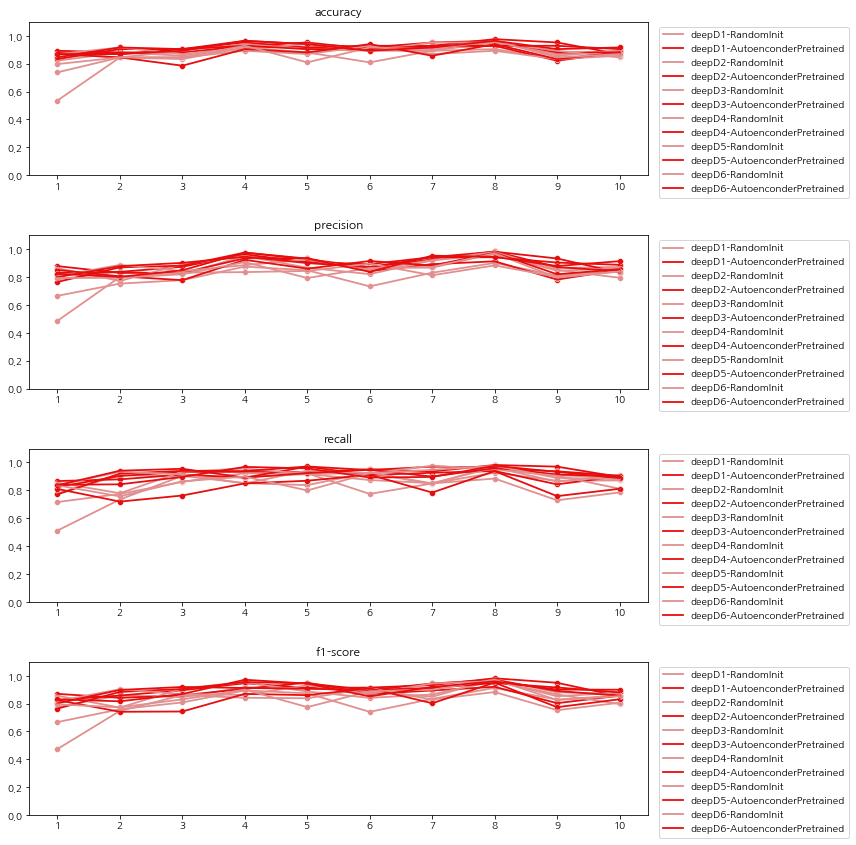

In [18]:
import seaborn as sns 

fig = plt.figure(figsize=(12, 12))
axes = fig.subplots(4, 1).flatten() 

color = ["#e18f8f", "#e70d0d", "#000000"]

for i, eva in enumerate(["accuracy", "precision", "recall", "f1-score"]):
    for k, v in enumerate(dic_model2eval):
        for j, dic_m in enumerate(dic_model2eval[v]):
            for model_name in dic_m:
                lw = 1 
                if "deep" in model_name:
                    lw = 1.8
                sns.lineplot(x=list(range(1, len(dic_m[model_name][eva])+1)), y=dic_m[model_name][eva], linewidth=lw, ax=axes[i], color=color[j], label=f"{model_name}")
                sns.scatterplot(x=list(range(1, len(dic_m[model_name][eva])+1)), y=dic_m[model_name][eva], ax=axes[i], color=color[j])

    axes[i].set_title(eva)
    axes[i].set_xticks(list(range(1, len(dic_m[model_name][eva])+1)))
    axes[i].set_ylim(0.0, 1.1)
    axes[i].legend(bbox_to_anchor=(1.01, 1.0))

plt.tight_layout()   
plt.show()

<br> 

아래는 10개의 fold의 각 지표 계산 결과에 대한 평균을 보여주는 그림이다. 

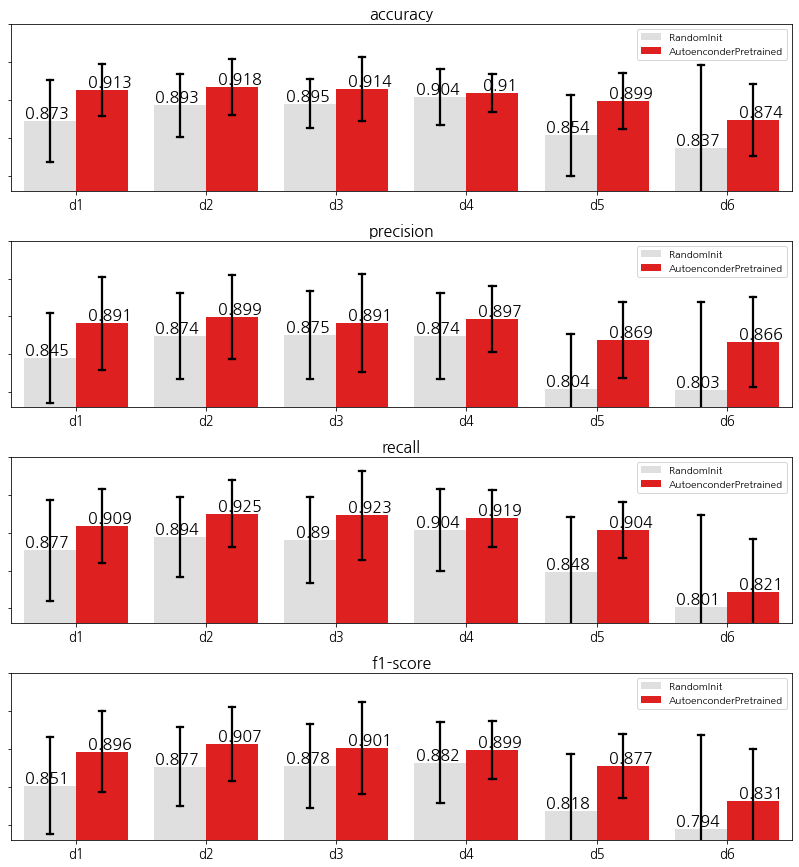

In [56]:
import seaborn as sns 
dic_eva = {"version": [], "model": [], "accuracy": [], "precision": [], "recall": [], "f1-score": []}
for version in dic_model2eval:  
    for dic_model in dic_model2eval[version]: 
        dic_val = list(dic_model.values())[0]
        len_m = len(dic_val["accuracy"])
        dic_eva["model"].extend([list(dic_model.keys())[0][7:]] * len_m)
        dic_eva["version"].extend([version] * len_m)
                                
        for m in ["accuracy", "precision", "recall", "f1-score"]: 
            dic_eva[m].extend(dic_val[m])


df = pd.DataFrame(dic_eva)
df = df.sort_values(by=['version', 'model'], ascending=[True, False])

fig = plt.figure(figsize=(14, 15))
# fig = plt.figure(figsize=(17, 10))
axes = fig.subplots(4, 1).flatten() 

for i, metric in enumerate(["accuracy", "precision", "recall", "f1-score"]): 
    custom_colors = {"RandomInit": "#dfdfdf", "AutoenconderPretrained": "red", "AutoenconderPretrained_BRCA": "#000000"}
    bars = sns.barplot(data=df, x="version", y=metric, hue='model',  
                       palette=custom_colors, ax=axes[i], width=0.8, 
                       ci="sd", capsize=.1, errcolor="k", linewidth=1)
    axes[i].set_title(metric, fontsize=16)

    axes[i].legend(bbox_to_anchor=(1.0, 1.0))    

    for j, b in enumerate(bars.patches):
        # print(j, b)
        if b.get_height() == 0: continue
        if j > 5: w=0.06
        elif i == 2 and j == 2: w=0.02
        else: w=-0.02
        
        _=axes[i].text(b.get_x()+b.get_width()*(1/2)+w, b.get_height() + 0.005, \
                round(b.get_height(), 3), ha='center', fontsize=16, color='k')
        #b.set_edgecolor('black')  # 테두리 색상 설정
        #b.set_linewidth(0.5)  # 테두리 두께 설정
        
    axes[i].set_ylim(0.78, 1.0)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), fontsize=13)
    axes[i].set_yticklabels([])
    axes[i].set_xlabel('')  # x축 레이블 비움
    axes[i].set_ylabel('')  # y축 레이블 비움
    
# sns.despine(left=True)   
# plt.tight_layout()
fig.subplots_adjust(hspace=0.3)
plt.show()

6개의 구조 모두 미세조정 모델이 랜덤 가중치 모델보다 더 우수한 성능을 보였다.